# Oplevering uitwerking van de casus
- uiterlijk woensdag 8 januari 2020 om 24:00.
- inleveropdracht ELO Studieroute ‘MCL.19 Machine Learning’.
- Per team één ZIP-file met:
- één Jupyter notebook, dat op andere computer uitgevoerd kan worden (let op path van files)
- 1ste cell: naam casus + korte beschrijving doel casus + referentie (bron)dataset
- 2de cell: teamleden.
- 3de cell: versies van de gebruikte libraries, conform colleges.
- één folder ‘datasets' met de gebruikte datasets en
- ZIP filenaam bevat teamnummer.
- Presentatie: vrijdag 10 januari 2020, in lokaal AB4.26 (De Nieuwe Bibliotheek)
Succes Stefan, Peter
(MCL Team 2019-2020)

## Weersvoorspelling Maastricht juni 2020

In deze casus wordt er voorspelt wat de neerslag en de temperatuur zal zijn in Maastricht. Deze voorspelling wordt gedaan voor de maand juni in 2020.

#### Referentie:
KNMI http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi

### Team: 6
1. Florian Maters,
2. Kento Bergsma,
3. David van der Zande,
4. Ahasan Rajaratnam

### versies van de gebruikte libraries
- Pandas: 0.25.1
- Numpy: 1.16.5
- Sklearn: 0.21.3
- Matplotlib: 3.1.1
- Seaborn: 0.9.0

# Description
YYYYMMDD = Datum (YYYY=jaar MM=maand DD=dag)
### Temperatuur
TG = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius)<br> 
TN = Minimum temperatuur (in 0.1 graden Celsius)<br>
TNH = Uurvak waarin TN is gemeten<br>
TX = Maximum temperatuur (in 0.1 graden Celsius)<br>
TXH = Uurvak waarin TX is gemeten<br>
### Neerslag
DR = Duur van de neerslag (in 0.1 uur)<br>
RH = Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)<br>
RHX = Hoogste uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)<br> 
RHXH = Uurvak waarin RHX is gemeten

In [1]:
# http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi

# Importing libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib 
import seaborn as sns


# Machine Learning
from sklearn import preprocessing, svm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

# pd.set_option('display.max_rows', df.shape[0]+1)

df = pd.read_csv('data/maastricht.csv', low_memory=False)
df1 = pd.read_csv('data/location.csv')
df['STN'] = df['STN'].map(df1.set_index('STN')['NAME'])

df = df[['STN', 'YYYYMMDD', 'TG', 'TN', 'TNH', 'TX', 'TXH', 'DR', 'RH', 'RHX', 'RHXH', ]]
df['Datum'] = df['YYYYMMDD'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

# Datum opsplitsen in losse kolommen
df['Jaar'] = pd.DatetimeIndex(df['Datum']).year
df['Maand'] = pd.DatetimeIndex(df['Datum']).month
df['Dag'] = pd.DatetimeIndex(df['Datum']).day

# Zet waarde van meten in 0.1 graden Celsius naar meten in 1 graden Celsius
df['TN'] *= 0.1
df['TX'] *= 0.1
df['TG'] *= 0.1

# Zet waarde van meten in 0.1 uur naar meten in 1 uur
df['DR'] *= 0.1

# Laat alleen de maand juni zien
df = df[df['Maand'] == 6]
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3420 entries, 151 to 41453
Data columns (total 15 columns):
STN         3420 non-null object
YYYYMMDD    3420 non-null int64
TG          3420 non-null float64
TN          3420 non-null float64
TNH         2070 non-null float64
TX          3420 non-null float64
TXH         2070 non-null float64
DR          1890 non-null float64
RH          1890 non-null float64
RHX         1890 non-null float64
RHXH        786 non-null float64
Datum       3420 non-null datetime64[ns]
Jaar        3420 non-null int64
Maand       3420 non-null int64
Dag         3420 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(4), object(1)
memory usage: 427.5+ KB
None


,STN,YYYYMMDD,TG,TN,TNH,TX,TXH,DR,RH,RHX,RHXH,Datum,Jaar,Maand,Dag
151,MAASTRICHT,19060601,10.3,7.5,NaN,13.7,NaN,NaN,NaN,NaN,NaN,1906-06-01,1906,6,1
152,MAASTRICHT,19060602,9.8,6.0,NaN,13.8,NaN,NaN,NaN,NaN,NaN,1906-06-02,1906,6,2
153,MAASTRICHT,19060603,9.3,7.7,NaN,12.2,NaN,NaN,NaN,NaN,NaN,1906-06-03,1906,6,3
154,MAASTRICHT,19060604,9.7,7.6,NaN,12.3,NaN,NaN,NaN,NaN,NaN,1906-06-04,1906,6,4
155,MAASTRICHT,19060605,9.8,5.6,NaN,14.9,NaN,NaN,NaN,NaN,NaN,1906-06-05,1906,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41449,MAASTRICHT,20190626,23.4,18.1,24.0,28.9,15.0,0.0,0.0,0.0,1.0,2019-06-26,2019,6,26
41450,MAASTRICHT,20190627,19.7,14.4,4.0,26.2,15.0,0.0,0.0,0.0,1.0,2019-06-27,2019,6,27
41451,MAASTRICHT,20190628,19.5,11.9,4.0,26.5,16.0,0.0,0.0,0.0,1.0,2019-06-28,2019,6,28
41452,MAASTRICHT,20190629,25.4,13.0,4.0,33.7,16.0,0.0,0.0,0.0,1.0,2019-06-29,2019,6,29


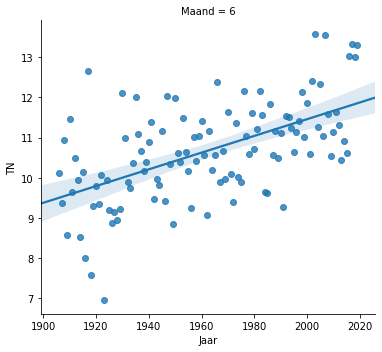

In [2]:
dfTemp = df[['YYYYMMDD', 'Datum', 'TN', 'TX', 'TG', 'Jaar', 'Maand', 'Dag']]
dfTempMin = dfTemp[['Datum', 'TN', 'Jaar', 'Maand', 'Dag']]
dfTempMinMean = dfTempMin.groupby(['Jaar', 'Maand'],as_index=False)['TN'].mean()
sns.lmplot(x='Jaar', y='TN', data=dfTempMinMean, col="Maand", col_wrap=3)

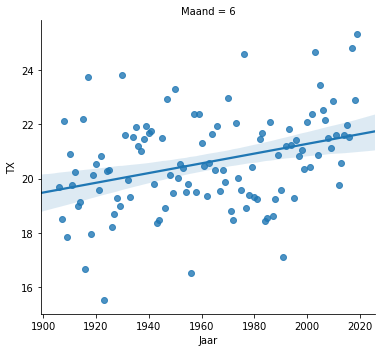

In [3]:
dfTempMax = dfTemp[['Datum', 'TX', 'Jaar', 'Maand', 'Dag']]
dfTempMaxMean = dfTempMax.groupby(['Jaar', 'Maand'],as_index=False)['TX'].mean()
sns.lmplot(x='Jaar', y='TX', data=dfTempMaxMean, col="Maand", col_wrap=3)

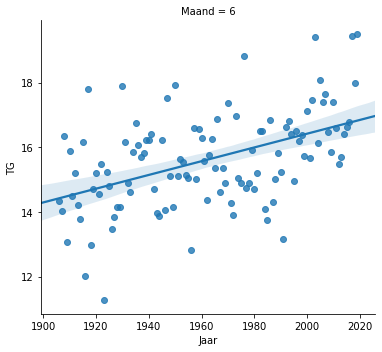

In [4]:
dfTempGem = dfTemp[['Datum', 'TG', 'Jaar', 'Maand', 'Dag']]

dfTempGemMean = dfTempGem.groupby(['Jaar', 'Maand'],as_index=False)['TG'].mean()

dfTempGemMean = dfTempGem.groupby(['Jaar', 'Maand'],as_index=False)['TG'].mean()
sns.lmplot(x='Jaar', y='TG', data=dfTempGemMean, col="Maand", col_wrap=3)

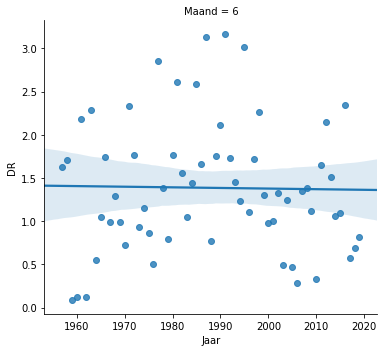

In [5]:
dfRegen = df[['YYYYMMDD', 'Datum', 'DR', 'Jaar', 'Maand', 'Dag']]
dfRegenMean = dfRegen.groupby(['Jaar', 'Maand'],as_index=False)['DR'].mean()
dfRegenMean = dfRegenMean.dropna()
sns.lmplot(x='Jaar', y='DR', data=dfRegenMean, col='Maand', col_wrap=3)

Coefficients: 
 [0.02788035]
Mean squared error: 1.76
Coefficient of determination: -0.20
Gemiddelde temp juni 2020: 17.12


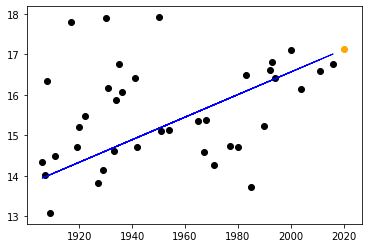

In [6]:
dataXTemp = dfTempGemMean['Jaar'].to_numpy()
dataXTemp = np.reshape(dataXTemp, (-1, 1))
dataYTemp = dfTempGemMean['TG'].to_numpy()

XTrainTemp, XTestTemp, YTrainTemp, YTestTemp = train_test_split(
    dataXTemp, dataYTemp, test_size=0.33, random_state=2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(XTrainTemp, YTrainTemp)

# Make predictions using the testing set
YPredTemp = regr.predict(XTestTemp)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(YTestTemp, YPredTemp))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(YTestTemp, YPredTemp))

print('Gemiddelde temp juni 2020: %.2f'
      % regr.predict(X=[[2020]]))

# Plot outputs
plt.scatter(XTestTemp, YTestTemp, color='black')
plt.plot(XTestTemp, YPredTemp, color='blue', linewidth=1)
plt.scatter(2020, regr.predict(X=[[2020]]), color='orange')

plt.show()

Coefficients: 
 [0.00311421]
Mean squared error: 0.48
Coefficient of determination: -0.08
Gemiddelde duur van regen in juni 2020 in uren: 1.45


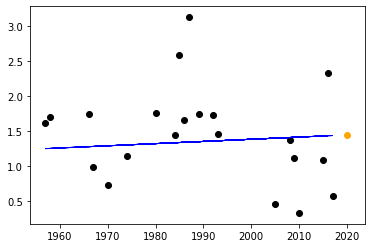

In [7]:
dataXRegen = dfRegenMean['Jaar'].to_numpy()
dataXRegen = np.reshape(dataXRegen, (-1, 1))
dataYRegen = dfRegenMean['DR'].to_numpy()

XTrainRegen, XTestRegen, YTrainRegen, YTestRegen = train_test_split(
    dataXRegen, dataYRegen, test_size=0.33, random_state=2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(XTrainRegen, YTrainRegen)

# Make predictions using the testing set
YPredRegen = regr.predict(XTestRegen)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(YTestRegen, YPredRegen))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(YTestRegen, YPredRegen))

print('Gemiddelde duur van regen in juni 2020 in uren: %.2f'
      % regr.predict(X=[[2020]]))

# Plot outputs
plt.scatter(XTestRegen, YTestRegen, color='black')
plt.plot(XTestRegen, YPredRegen, color='blue', linewidth=1)
plt.scatter(2020, regr.predict(X=[[2020]]), color='orange')

plt.show()